In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [4]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        dataset = pd.read_csv(self.file_path)
        X = dataset.iloc[:, 3:13].values
        y = dataset.iloc[:, 13].values
        Xc = dataset.iloc[:, 3:13]
        yc = dataset.iloc[:, 13]
        labelencoder_X_1 = LabelEncoder()
        X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
        labelencoder_X_2 = LabelEncoder()
        X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

        onehotencoder = OneHotEncoder(categories='auto', drop='first')
        X = onehotencoder.fit_transform(X).toarray()

        # Splitting data into training, testing, and validation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_val = sc.transform(X_val)
        X_test = sc.transform(X_test)

        # return X_train, X_val, X_test, y_train, y_val, y_test,Xc, yc
        return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer):
        # model = tf.keras.Sequential([
        #     tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape=(input_shape,)),
        #     tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'),
        #     tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
        # ])
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            # tf.keras.layers.Dense(units=96, activation='relu'),
            # tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            # tf.keras.layers.Dense(Dropout(rate=0.5)),
            tf.keras.layers.Dense(units=96, activation='relu'),
            # tf.keras.layers.Dense(Dropout(rate=0.5)),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [6]:
# Example usage:
file_path = "Churn_Modelling.csv"
data_preprocessor = DataPreprocessor(file_path)
# X_train, X_val, X_test, y_train, y_val, y_test , Xc, yc= data_preprocessor.load_data()
X_train, X_val, X_test, y_train, y_val, y_test = data_preprocessor.load_data()

In [7]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [8]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((6000, 16925), (2000, 16925), (2000, 16925), (6000,))

In [9]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5824/6000 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.7905

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 466us/sample - loss: 0.5890 - accuracy: 0.7887 - val_loss: 0.5476 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 2/50
6000/6000 [==============================] - 2s 271us/sample - loss: 0.5088 - accuracy: 0.7975 - val_loss: 0.5225 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 3/50
6000/6000 [==============================] - 2s 258us/sample - loss: 0.4860 - accuracy: 0.7975 - val_loss: 0.5167 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 4/50
6000/6000 [==============================] - 2s 295us/sample - loss: 0.4540 - accuracy: 0.7975 - val_loss: 0.5137 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 5/50
6000/6000 [==============================] - 2s 284us/sample - loss: 0.3836 - accuracy: 0.7975 - val_loss: 0.5085 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 6/50
6000/6000 [==============================] - 2s 284us/sample - loss: 0.2611 - accuracy: 0.7975 - val_loss: 0.5110 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 7/50
6000/6000 [=======================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training model with SGD_momentum optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7917

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 327us/sample - loss: 0.5161 - accuracy: 0.7917 - val_loss: 0.5048 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 2/50
6000/6000 [==============================] - 2s 265us/sample - loss: 0.2625 - accuracy: 0.8770 - val_loss: 0.6950 - val_accuracy: 0.6055 - lr: 0.0100
Epoch 3/50
6000/6000 [==============================] - 2s 264us/sample - loss: 0.0402 - accuracy: 0.9900 - val_loss: 0.6388 - val_accuracy: 0.7775 - lr: 0.0100
Epoch 4/50
6000/6000 [==============================] - 2s 300us/sample - loss: 0.0182 - accuracy: 0.9985 - val_loss: 0.5904 - val_accuracy: 0.7750 - lr: 0.0100
Epoch 5/50
6000/6000 [==============================] - 2s 272us/sample - loss: 8.9631e-04 - accuracy: 1.0000 - val_loss: 0.6416 - val_accuracy: 0.7685 - lr: 0.0050
Epoch 6/50
6000/6000 [==============================] - 1s 236us/sample - loss: 4.2788e-04 - accuracy: 1.0000 - val_loss: 0.6600 - val_accuracy: 0.7705 - lr: 0.0050
Epoch 7/50
6000/6000 [===============

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Nesterov optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5856/6000 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.7809

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 322us/sample - loss: 0.5190 - accuracy: 0.7818 - val_loss: 0.5077 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 2/50
6000/6000 [==============================] - 2s 264us/sample - loss: 0.2754 - accuracy: 0.8788 - val_loss: 0.5315 - val_accuracy: 0.7460 - lr: 0.0100
Epoch 3/50
6000/6000 [==============================] - 2s 303us/sample - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.5629 - val_accuracy: 0.7775 - lr: 0.0100
Epoch 4/50
6000/6000 [==============================] - 2s 268us/sample - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.6060 - val_accuracy: 0.7705 - lr: 0.0100
Epoch 5/50
6000/6000 [==============================] - 2s 252us/sample - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.5934 - val_accuracy: 0.7855 - lr: 0.0050
Epoch 6/50
6000/6000 [==============================] - 2s 308us/sample - loss: 3.8290e-04 - accuracy: 1.0000 - val_loss: 0.6157 - val_accuracy: 0.7835 - lr: 0.0050
Epoch 7/50
6000/6000 [===================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with RMSprop optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5920/6000 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.7943

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 531us/sample - loss: 0.4819 - accuracy: 0.7940 - val_loss: 0.6527 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 327us/sample - loss: 0.2474 - accuracy: 0.8952 - val_loss: 2.0267 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 305us/sample - loss: 0.1066 - accuracy: 0.9613 - val_loss: 0.8096 - val_accuracy: 0.8055 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 328us/sample - loss: 0.0496 - accuracy: 0.9828 - val_loss: 0.6559 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 413us/sample - loss: 0.0151 - accuracy: 0.9943 - val_loss: 1.2807 - val_accuracy: 0.8130 - lr: 5.0000e-04
Epoch 6/50
6000/6000 [==============================] - 3s 534us/sample - loss: 0.0059 - accuracy: 0.9985 - val_loss: 1.8640 - val_accuracy: 0.8165 - lr: 5.0000e-04
Epoch 7/50
6000/6000 [===============

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Adagrad optimizer...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5952/6000 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.7964

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 446us/sample - loss: 0.6387 - accuracy: 0.7967 - val_loss: 0.6365 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 366us/sample - loss: 0.5681 - accuracy: 0.7975 - val_loss: 0.5941 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 361us/sample - loss: 0.5175 - accuracy: 0.7975 - val_loss: 0.5658 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 350us/sample - loss: 0.4911 - accuracy: 0.7975 - val_loss: 0.5534 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 343us/sample - loss: 0.4729 - accuracy: 0.7975 - val_loss: 0.5469 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 403us/sample - loss: 0.4555 - accuracy: 0.7975 - val_loss: 0.5434 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 7/50
6000/6000 [=======================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Adadelta optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5984/6000 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.7945

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 472us/sample - loss: 0.6682 - accuracy: 0.7945 - val_loss: 0.6863 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 299us/sample - loss: 0.6641 - accuracy: 0.7965 - val_loss: 0.6846 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 354us/sample - loss: 0.6599 - accuracy: 0.7975 - val_loss: 0.6828 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 410us/sample - loss: 0.6554 - accuracy: 0.7975 - val_loss: 0.6809 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 363us/sample - loss: 0.6508 - accuracy: 0.7975 - val_loss: 0.6789 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 321us/sample - loss: 0.6460 - accuracy: 0.7975 - val_loss: 0.6767 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 7/50
6000/6000 [=======================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Adam optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5920/6000 [============================>.] - ETA: 0s - loss: 0.4905 - accuracy: 0.7949

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 325us/sample - loss: 0.4887 - accuracy: 0.7962 - val_loss: 0.6458 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 1s 237us/sample - loss: 0.1283 - accuracy: 0.9452 - val_loss: 0.6540 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 294us/sample - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.8065 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 281us/sample - loss: 8.7295e-05 - accuracy: 1.0000 - val_loss: 0.9279 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 1s 238us/sample - loss: 3.4802e-05 - accuracy: 1.0000 - val_loss: 0.9569 - val_accuracy: 0.8205 - lr: 5.0000e-04
Epoch 6/50
6000/6000 [==============================] - 2s 291us/sample - loss: 2.7843e-05 - accuracy: 1.0000 - val_loss: 0.9842 - val_accuracy: 0.8200 - lr: 5.0000e-04
Epoch 7/50
6000/6000 [===

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with AMSGrad optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5984/6000 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.7973

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 373us/sample - loss: 0.4866 - accuracy: 0.7975 - val_loss: 0.6502 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 270us/sample - loss: 0.1121 - accuracy: 0.9502 - val_loss: 0.6151 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 271us/sample - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.7468 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 273us/sample - loss: 1.0757e-04 - accuracy: 1.0000 - val_loss: 0.7462 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 307us/sample - loss: 2.8623e-05 - accuracy: 1.0000 - val_loss: 0.7758 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 271us/sample - loss: 2.1963e-05 - accuracy: 1.0000 - val_loss: 0.7881 - val_accuracy: 0.8355 - lr: 5.0000e-04
Epoch 7/50
6000/6000 [=======

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training model with AdamW optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5824/6000 [============================>.] - ETA: 0s - loss: 0.4827 - accuracy: 0.7965

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 386us/sample - loss: 0.4814 - accuracy: 0.7975 - val_loss: 0.6387 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 283us/sample - loss: 0.1122 - accuracy: 0.9557 - val_loss: 0.4451 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 268us/sample - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.6381 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 280us/sample - loss: 1.9550e-04 - accuracy: 1.0000 - val_loss: 0.6760 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 302us/sample - loss: 1.0520e-04 - accuracy: 1.0000 - val_loss: 0.6951 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 272us/sample - loss: 9.3238e-05 - accuracy: 1.0000 - val_loss: 0.6799 - val_accuracy: 0.8315 - lr: 5.0000e-04
Epoch 7/50
6000/6000 [=======

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training model with Yogi optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5856/6000 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.7978

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 580us/sample - loss: 0.4698 - accuracy: 0.7977 - val_loss: 0.4403 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 2/50
6000/6000 [==============================] - 2s 362us/sample - loss: 0.0996 - accuracy: 0.9587 - val_loss: 0.6177 - val_accuracy: 0.7760 - lr: 0.0100
Epoch 3/50
6000/6000 [==============================] - 2s 361us/sample - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.6787 - val_accuracy: 0.7515 - lr: 0.0100
Epoch 4/50
6000/6000 [==============================] - 2s 410us/sample - loss: 7.5220e-04 - accuracy: 0.9995 - val_loss: 1.0904 - val_accuracy: 0.7545 - lr: 0.0100
Epoch 5/50
6000/6000 [==============================] - 2s 373us/sample - loss: 5.8909e-04 - accuracy: 0.9997 - val_loss: 1.0474 - val_accuracy: 0.7520 - lr: 0.0050
Epoch 6/50
6000/6000 [==============================] - 2s 381us/sample - loss: 3.7070e-04 - accuracy: 0.9997 - val_loss: 1.0652 - val_accuracy: 0.7515 - lr: 0.0050
Epoch 7/50
6000/6000 [===========

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Nadam optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5952/6000 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.7955

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 505us/sample - loss: 0.4864 - accuracy: 0.7962 - val_loss: 0.8672 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 372us/sample - loss: 0.1179 - accuracy: 0.9553 - val_loss: 1.0595 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 2s 376us/sample - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.8617 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 366us/sample - loss: 3.2033e-04 - accuracy: 0.9998 - val_loss: 1.2324 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 392us/sample - loss: 8.7599e-05 - accuracy: 1.0000 - val_loss: 1.2583 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 404us/sample - loss: 2.6446e-05 - accuracy: 1.0000 - val_loss: 1.3055 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 7/50
6000/6000 [===========

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training model with Adamax optimizer...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
5984/6000 [============================>.] - ETA: 0s - loss: 0.5062 - accuracy: 0.7916

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 3s 426us/sample - loss: 0.5066 - accuracy: 0.7913 - val_loss: 0.6881 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/50
6000/6000 [==============================] - 2s 282us/sample - loss: 0.4222 - accuracy: 0.7977 - val_loss: 0.4983 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 3/50
6000/6000 [==============================] - 1s 247us/sample - loss: 0.2858 - accuracy: 0.8862 - val_loss: 0.4180 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 4/50
6000/6000 [==============================] - 2s 288us/sample - loss: 0.1409 - accuracy: 0.9533 - val_loss: 0.3989 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 5/50
6000/6000 [==============================] - 2s 263us/sample - loss: 0.0658 - accuracy: 0.9807 - val_loss: 0.4633 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 6/50
6000/6000 [==============================] - 2s 286us/sample - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.8541 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 7/50
6000/6000 [=======================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.7805, Precision - 0.7893, Recall - 0.7805, F1-score - 0.7845, Convergence Speed - 17 epochs, Training Time - 31.66 seconds
SGD_momentum: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, Convergence Speed - 11 epochs, Training Time - 18.92 seconds
Nesterov: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, Convergence Speed - 11 epochs, Training Time - 20.82 seconds
RMSprop: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, Convergence Speed - 11 epochs, Training Time - 30.06 seconds
Adagrad: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, Convergence Speed - 21 epochs, Training Time - 52.59 seconds
Adadelta: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, Convergence Speed - 50 epochs, Training Time - 85.37 seconds
Adam: Test Accuracy - 0.7975, Precision - 0.6360, Recall - 0.7975, F1-score - 0.7077, C

In [15]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Customer Churn"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Customer Churn,6000,16925,int64,FNN,SGD,0.7805,0.789323,0.7805,0.784533,17,31.659004,0.589030,0.547633
1,Customer Churn,6000,16925,int64,FNN,SGD_momentum,0.7975,0.636006,0.7975,0.707656,11,18.922165,0.516069,0.504822
2,Customer Churn,6000,16925,int64,FNN,Nesterov,0.7975,0.636006,0.7975,0.707656,11,20.819669,0.519050,0.507740
3,Customer Churn,6000,16925,int64,FNN,RMSprop,0.7975,0.636006,0.7975,0.707656,11,30.058760,0.481916,0.652713
4,Customer Churn,6000,16925,int64,FNN,Adagrad,0.7975,0.636006,0.7975,0.707656,21,52.589148,0.638747,0.636483
5,Customer Churn,6000,16925,int64,FNN,Adadelta,0.7975,0.636006,0.7975,0.707656,50,85.370563,0.668224,0.686312
6,Customer Churn,6000,16925,int64,FNN,Adam,0.7975,0.636006,0.7975,0.707656,11,18.469265,0.488714,0.645801
7,Customer Churn,6000,16925,int64,FNN,AMSGrad,0.8305,0.824170,0.8305,0.790066,12,20.916592,0.486642,0.650221
8,Customer Churn,6000,16925,int64,FNN,AdamW,0.8260,0.806070,0.8260,0.806698,12,21.872087,0.481416,0.638660
9,Customer Churn,6000,16925,int64,FNN,Yogi,0.7975,0.636006,0.7975,0.707656,11,27.436432,0.469818,0.440271


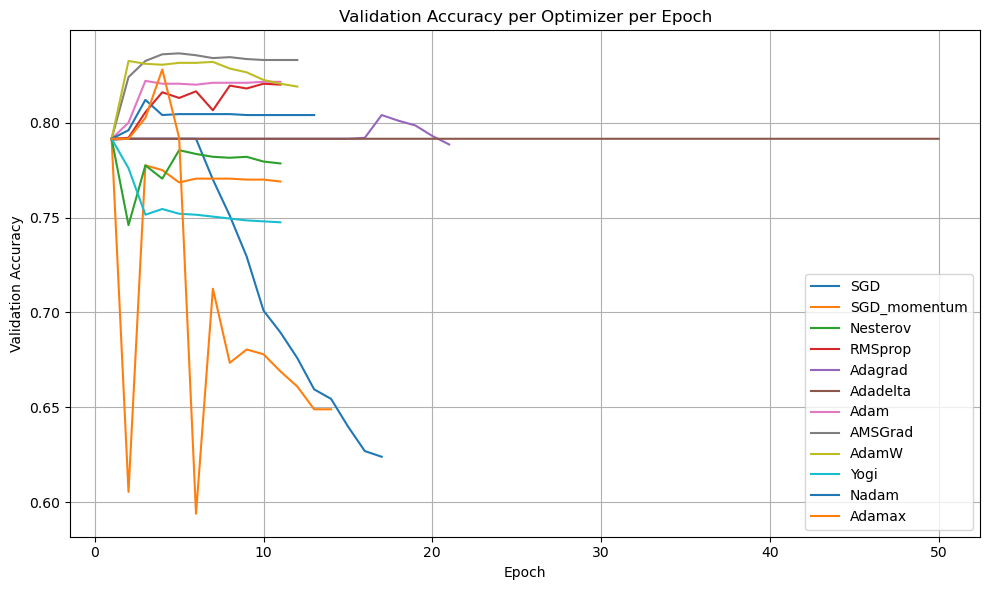

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


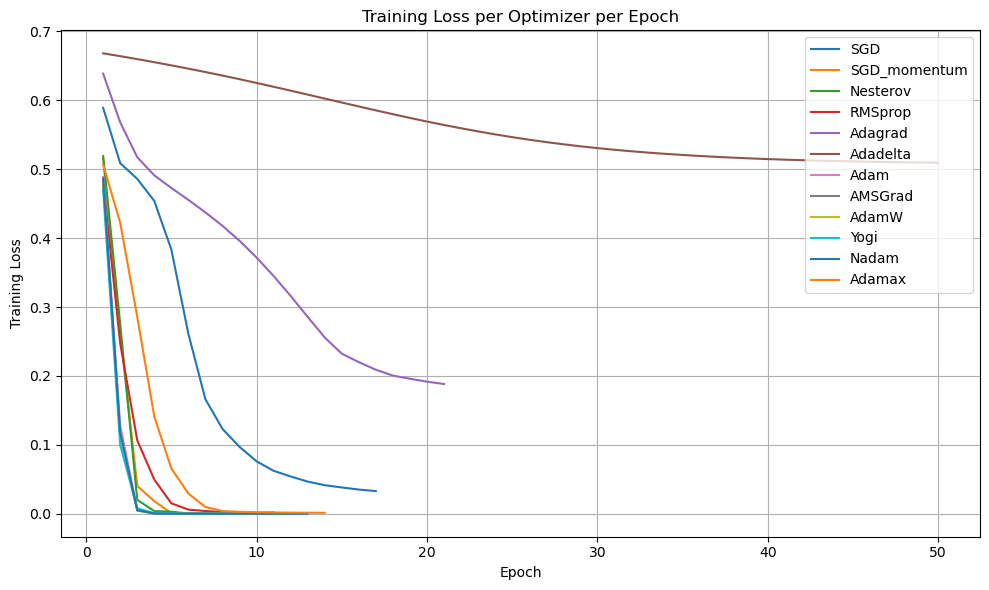

In [17]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
final_df.to_csv('Customer Churn_nn_r(3).csv', index=False)

In [48]:
# df = pd.read_csv('Churn_Modelling.csv')

############################################ Before Presentation ######################################################

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [21]:
import tensorflow as tf

# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [12]:
# import time
# import tensorflow as tf
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

# import time
# import tensorflow as tf
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense


# class DataPreprocessor:
#     def __init__(self, file_path):
#         self.file_path = file_path
#         self.X_train = None
#         self.X_test = None
#         self.y_train = None
#         self.y_test = None

#     def load_data(self):
#         dataset = pd.read_csv(self.file_path)
#         X = dataset.iloc[:, 3:13].values
#         y = dataset.iloc[:, 13].values

#         labelencoder_X_1 = LabelEncoder()
#         X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])

#         labelencoder_X_2 = LabelEncoder()
#         X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

#         onehotencoder = OneHotEncoder(categories='auto')
#         X = onehotencoder.fit_transform(X).toarray()

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         self.X_train = X_train
#         self.X_test = X_test
#         self.y_train = y_train
#         self.y_test = y_test


In [13]:
# import time
# import matplotlib.pyplot as plt

# # Define NeuralNetworkModel class
# class NeuralNetworkModel:
#     def __init__(self):
#         self.model = None

#     def build_ann(self, input_shape, optimizer='adam'):
#         model = tf.keras.Sequential()
#         model.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape=(input_shape,)))
#         model.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'))
#         model.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
#         model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#         self.model = model

#     def train(self, X_train, y_train, epochs=5, batch_size=10, validation_data=None):
#         history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=0)
#         return history

#     def evaluate(self, X_test, y_test):
#         return self.model.evaluate(X_test, y_test)

In [14]:
# # Example usage
# data_preprocessor = DataPreprocessor('Churn_Modelling.csv')
# data_preprocessor.load_data()

Training model with SGD optimizer...


C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Training model with Adam optimizer...
Training model with RMSprop optimizer...
Training model with Adagrad optimizer...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training model with Adadelta optimizer...
Training model with Adamax optimizer...
Training model with Nadam optimizer...

Results:
SGD: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 11.55 seconds
Adam: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 10.39 seconds
RMSprop: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 10.24 seconds
Adagrad: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 10.07 seconds
Adadelta: Test Accuracy - 0.7750, Convergence Speed - 5 epochs, Training Time - 10.13 seconds
Adamax: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 10.84 seconds
Nadam: Test Accuracy - 0.7975, Convergence Speed - 5 epochs, Training Time - 13.

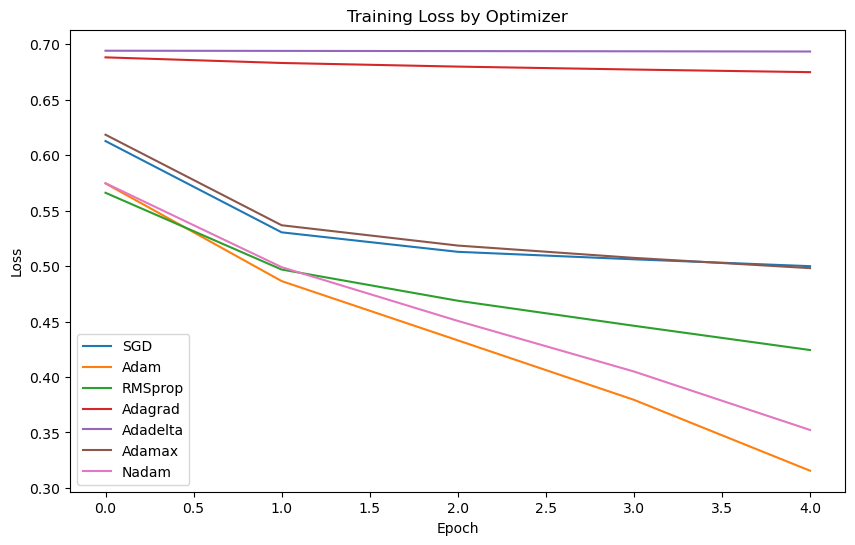

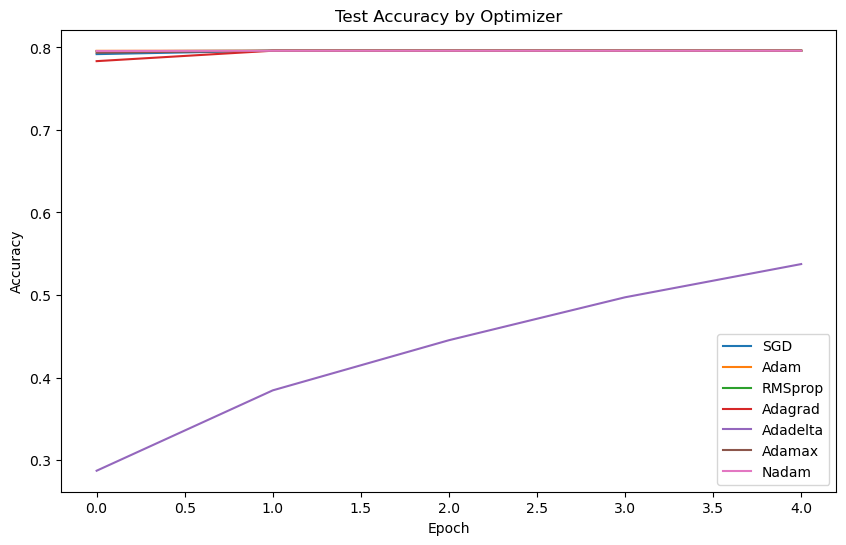

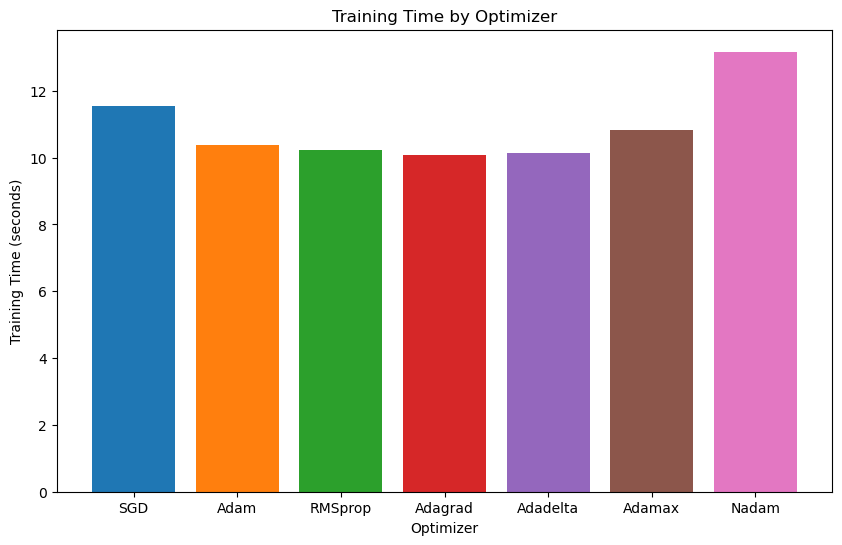

In [15]:
# # List of optimizers to test for NN
# optimizers = {
#     'SGD': 'SGD',
#     'Adam': 'adam',
#     'RMSprop': 'RMSprop',
#     'Adagrad': 'Adagrad',
#     'Adadelta': 'Adadelta',
#     'Adamax': 'Adamax',
#     'Nadam': 'Nadam'
# }

# results = {}

# for name, optimizer_name in optimizers.items():
#     print(f"Training model with {name} optimizer...")
#     model_instance = NeuralNetworkModel()
#     model_instance.build_ann(data_preprocessor.X_train.shape[1], optimizer=optimizer_name)
#     start_time = time.time()
#     history = model_instance.train(data_preprocessor.X_train, data_preprocessor.y_train, epochs=5, batch_size=32, validation_data=(data_preprocessor.X_test, data_preprocessor.y_test))
#     end_time = time.time()
#     test_loss, test_acc = model_instance.evaluate(data_preprocessor.X_test, data_preprocessor.y_test)
#     training_time = end_time - start_time
#     results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# # Print results
# print("\nResults:")
# for name, result in results.items():
#     print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
#           f"Convergence Speed - {result['convergence_speed']} epochs, "
#           f"Training Time - {result['training_time']:.2f} seconds")

# # Plot training history
# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.plot(result['history'].history['loss'], label=name)
# plt.title('Training Loss by Optimizer')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.plot(result['history'].history['accuracy'], label=name)
# plt.title('Test Accuracy by Optimizer')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.bar(name, result['training_time'])
# plt.title('Training Time by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Training Time (seconds)')
# plt.show()

In [16]:
# # Step 1: Collect results and metrics
# optimizer_metrics = {}  # Dictionary to store optimizer metrics

# for optimizer, result in results.items():
#     accuracy = result['test_accuracy']
#     loss = result['history'].history['loss'][-1]
#     training_time = result['training_time']
#     optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# # Step 2: Analyze metrics
# best_optimizer = None
# best_accuracy = 0
# lowest_loss = float('inf')
# shortest_training_time = float('inf')

# for optimizer, metrics in optimizer_metrics.items():
#     accuracy = metrics['accuracy']
#     loss = metrics['loss']
#     training_time = metrics['training_time']
    
#     # Determine the best optimizer based on accuracy, loss, and training time
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         lowest_loss = loss
#         shortest_training_time = training_time
#         best_optimizer = optimizer
#     elif accuracy == best_accuracy and loss < lowest_loss:
#         lowest_loss = loss
#         shortest_training_time = training_time
#         best_optimizer = optimizer
#     elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
#         shortest_training_time = training_time
#         best_optimizer = optimizer

# # Step 3: Print or return the best performing optimizer
# print(f"Best performing optimizer: {best_optimizer}")
# print(f"Accuracy: {best_accuracy:.4f}")
# print(f"Loss: {lowest_loss:.4f}")
# print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adam
Accuracy: 0.7975
Loss: 0.3155
Shortest Training Time: 10.39 seconds


Comparison of Optimizers:
          accuracy      loss  training_time
SGD         0.7975  0.499912      11.552151
Adam        0.7975  0.315521      10.387026
RMSprop     0.7975  0.424324      10.238477
Adagrad     0.7975  0.674821      10.072893
Adadelta    0.7750  0.693419      10.133498
Adamax      0.7975  0.498154      10.838018
Nadam       0.7975  0.352268      13.168955


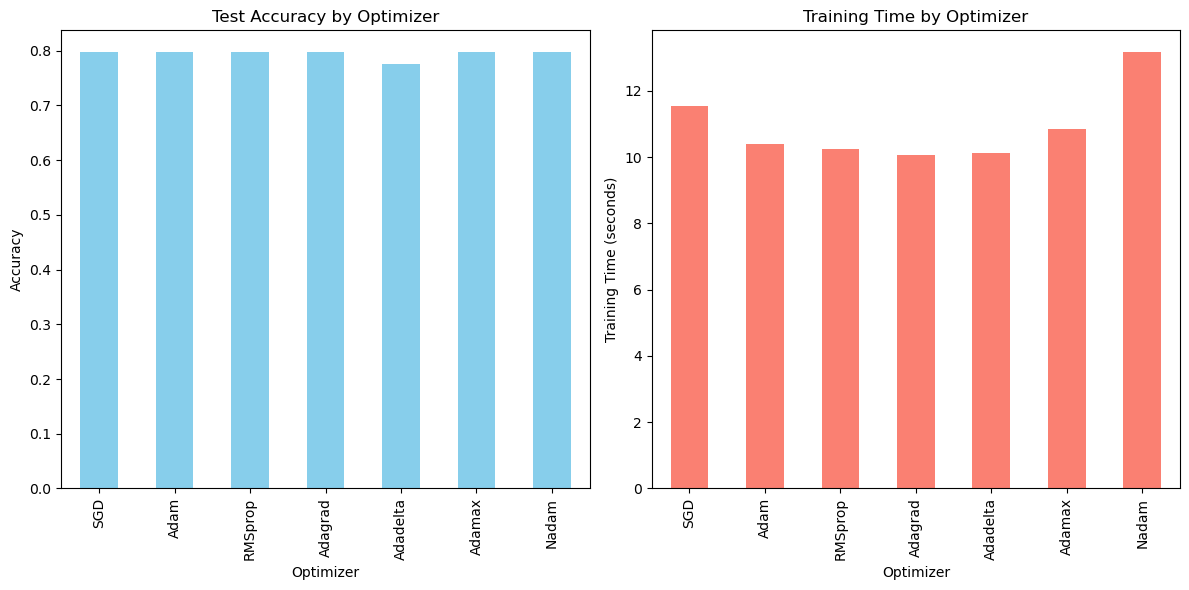

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Collect results and metrics
# optimizer_metrics = {}  # Dictionary to store optimizer metrics

# for optimizer, result in results.items():
#     accuracy = result['test_accuracy']
#     loss = result['history'].history['loss'][-1]
#     training_time = result['training_time']
#     optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# # Step 2: Create a dataframe for comparison
# df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# # Step 3: Plot the comparison using a table
# print("Comparison of Optimizers:")
# print(df)

# # Step 4: Plot the comparison using a graph
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# df['accuracy'].plot(kind='bar', color='skyblue')
# plt.title('Test Accuracy by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Accuracy')

# plt.subplot(1, 2, 2)
# df['training_time'].plot(kind='bar', color='salmon')
# plt.title('Training Time by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Training Time (seconds)')

# plt.tight_layout()
# plt.show()


In [80]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [81]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0

In [82]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [83]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [84]:
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [85]:
!pip install tensorflow-addons

In [86]:
# from tensorflow.keras.optimizers import Adam, SGD
# import tensorflow_addons as tfa

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow_addons.optimizers import Yogi
# from tensorflow_addons.optimizers import AdaBound, AMSGrad
# from tensorflow_addons.optimizers import AMSGrad
import time
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Adam


In [88]:
import time
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
import tensorflow_addons as tfa

# os.environ['CUDA_VISIBLE_DEVICES'] = ''

class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        dataset = pd.read_csv(self.file_path)
        X = dataset.iloc[:, 3:13].values
        y = dataset.iloc[:, 13].values

        labelencoder_X_1 = LabelEncoder()
        X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
        labelencoder_X_2 = LabelEncoder()
        X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

        onehotencoder = OneHotEncoder(categories='auto', drop='first')
        X = onehotencoder.fit_transform(X).toarray()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

In [89]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'),
            tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
        ])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, epochs=5, batch_size=10, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=0)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [90]:
# Load data
data_preprocessor = DataPreprocessor('Churn_Modelling.csv')
data_preprocessor.load_data()

Training model with SGD optimizer...


C:\Users\werka\miniconda3\envs\py310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Training model with SGD_Momentum optimizer...
Training model with SGD_Nesterov optimizer...
Training model with Adam optimizer...
Training model with Adam_AMSGrad optimizer...
Training model with RMSprop optimizer...
Training model with Adagrad optimizer...
Training model with Adadelta optimizer...
Training model with Adamax optimizer...
Training model with Nadam optimizer...
Training model with AdamW optimizer...
Training model with Yogi optimizer...

Results:
SGD: Test Accuracy - 0.7185, Convergence Speed - 100 epochs, Training Time - 258.13 seconds
SGD_Momentum: Test Accuracy - 0.6105, Convergence Speed - 100 epochs, Training Time - 267.69 seconds
SGD_Nesterov: Test Accuracy - 0.6455, Convergence Speed - 100 epochs, Training Time - 247.18 seconds
Adam: Test Accuracy - 0.7975, Convergence Speed - 100 epochs, Training Time - 246.61 seconds
Adam_AMSGrad: Test Accuracy - 0.7975, Convergence Speed - 100 epochs, Training Time - 265.22 seconds
RMSprop: Test Accuracy - 0.7985, Convergence S

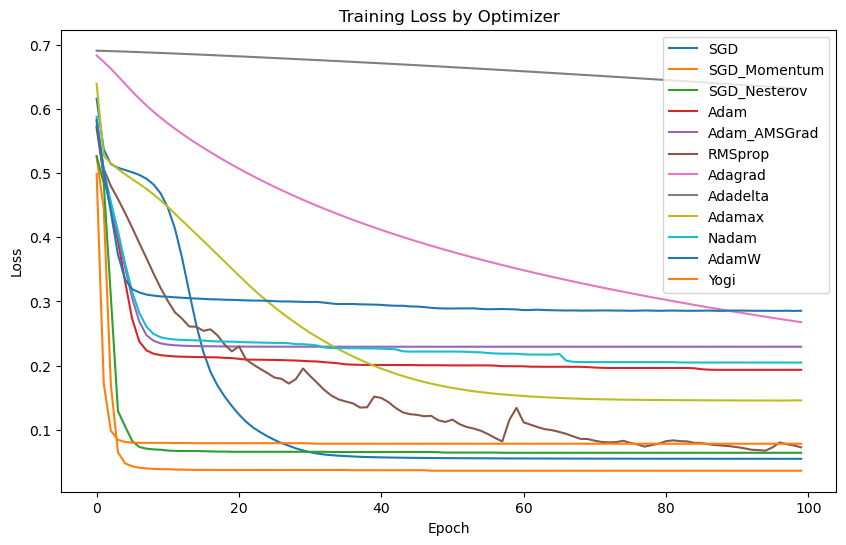

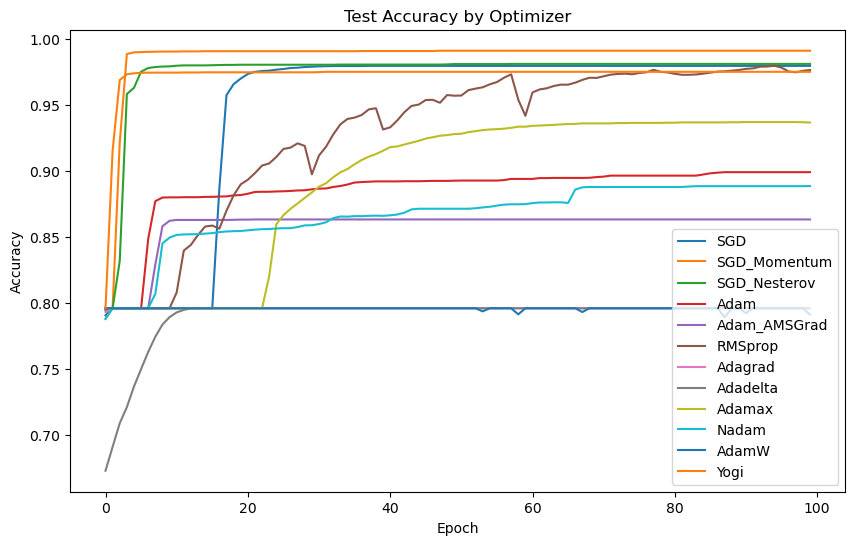

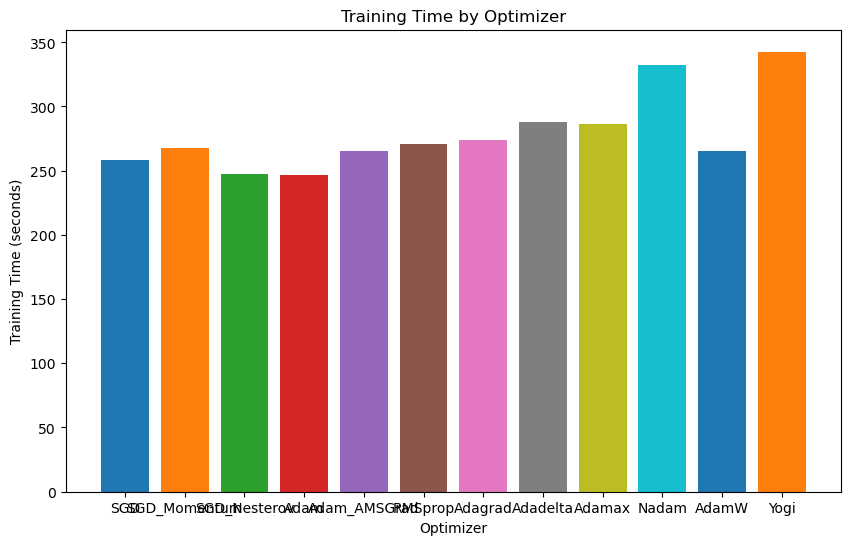

In [94]:
# List of optimizers to test
optimizers = {
    'SGD': SGD(),
    'SGD_Momentum': SGD(momentum=0.9),
    'SGD_Nesterov': SGD(momentum=0.9, nesterov=True),
    'Adam': Adam(),
    'Adam_AMSGrad': Adam(amsgrad=True),
    'RMSprop': RMSprop(),
    'Adagrad': Adagrad(),
    'Adadelta': Adadelta(),
    'Adamax': Adamax(),
    'Nadam': Nadam(),
    'AdamW': tfa.optimizers.AdamW(weight_decay=0.001),
    'Yogi': tfa.optimizers.Yogi(),
    # 'Lookahead_Adam': tfa.optimizers.Lookahead(Adam(), sync_period=6, slow_step_size=0.5)
}

results = {}
for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(data_preprocessor.X_train.shape[1], optimizer)
    start_time = time.time()
    history = model_instance.train(data_preprocessor.X_train, data_preprocessor.y_train, epochs=100, batch_size=32, validation_data=(data_preprocessor.X_test, data_preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(data_preprocessor.X_test, data_preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {
        'test_accuracy': test_acc,
        'convergence_speed': len(history.history['loss']),
        'training_time': training_time,
        'history': history
    }

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [97]:
# Assumption: The 'results' dictionary has been filled with training data as in your original code.

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]  # Get the last loss value
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for name, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < lowest_loss):
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = name
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = name

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")


Best performing optimizer: Adamax
Accuracy: 0.8065
Loss: 0.1458
Shortest Training Time: 286.41 seconds


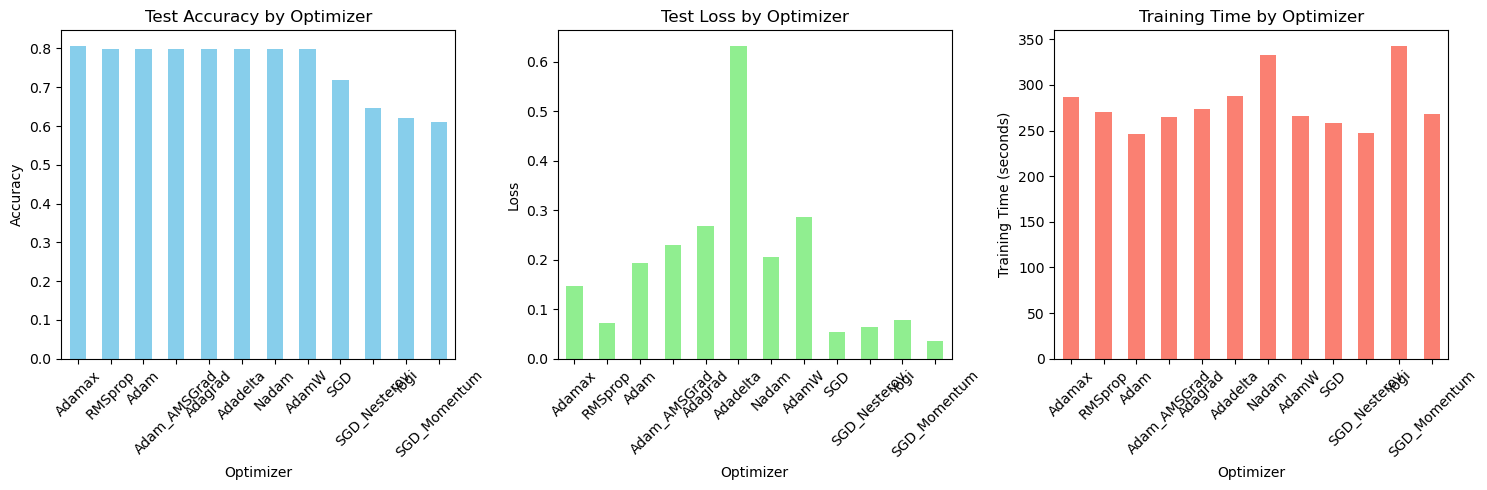

Comparison of Optimizers:
              accuracy      loss  training_time
Adamax          0.8065  0.145750     286.405773
RMSprop         0.7985  0.072562     270.762072
Adam            0.7975  0.193409     246.607675
Adam_AMSGrad    0.7975  0.229417     265.219135
Adagrad         0.7975  0.267723     274.114794
Adadelta        0.7975  0.631759     288.154123
Nadam           0.7975  0.204692     332.305185
AdamW           0.7975  0.285559     265.482799
SGD             0.7185  0.054659     258.125629
SGD_Nesterov    0.6455  0.064059     247.177080
Yogi            0.6210  0.078205     342.741735
SGD_Momentum    0.6105  0.036101     267.687102


In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'results' dictionary is populated with the training results from the earlier code

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss_history = result['history'].history['loss']
    if len(loss_history) > 0:  # Ensure there is at least one loss value
        loss = loss_history[-1]  # Get the last loss value
    else:
        loss = None
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows
df.sort_values('accuracy', ascending=False, inplace=True)  # Sort by accuracy in descending order

# Step 3: Plot the comparison using a graph
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
df['loss'].plot(kind='bar', color='lightgreen')
plt.title('Test Loss by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

# Step 4: Optionally, print the DataFrame for a text-based comparison
print("Comparison of Optimizers:")
print(df)